In [ ]:
using DelaySSAToolkit, Catalyst, DifferentialEquations, Plots, Latexify, StatsBase, LinearAlgebra

# Initiation time distribution

## Model reactions

In [2]:
# stepwise model of eukaryotic transcription initiation

initiation = @reaction_network begin
    (k₁,k₋₁), S₁ <--> S₂
    (k₂,k₋₂), S₂ <--> S₃
    (k₃,k₋₃), S₃ <--> S₄
    (k₄,k₋₄), S₄ <--> S₅
    (k₅,k₋₅), S₅ <--> S₆
    (k₆,k₋₆), S₆ <--> S₇
    (k₇,k₋₇), S₇ <--> S₈
    (k₈,k₋₈), S₈ <--> S₉
    k₉, S₉ --> S₁₀
    k₁₀, S₁₀ --> ∅
end k₁ k₋₁ k₂ k₋₂ k₃ k₋₃ k₄ k₋₄ k₅ k₋₅ k₆ k₋₆ k₇ k₋₇ k₈ k₋₈ k₉ k₁₀;

In [3]:
# check species

Catalyst.species(initiation)

10-element Vector{Any}:
 S₁(t)
 S₂(t)
 S₃(t)
 S₄(t)
 S₅(t)
 S₆(t)
 S₇(t)
 S₈(t)
 S₉(t)
 S₁₀(t)

In [4]:
# check reactions

Catalyst.reactions(initiation)

18-element Vector{Reaction}:
 k₁, S₁ --> S₂
 k₋₁, S₂ --> S₁
 k₂, S₂ --> S₃
 k₋₂, S₃ --> S₂
 k₃, S₃ --> S₄
 k₋₃, S₄ --> S₃
 k₄, S₄ --> S₅
 k₋₄, S₅ --> S₄
 k₅, S₅ --> S₆
 k₋₅, S₆ --> S₅
 k₆, S₆ --> S₇
 k₋₆, S₇ --> S₆
 k₇, S₇ --> S₈
 k₋₇, S₈ --> S₇
 k₈, S₈ --> S₉
 k₋₈, S₉ --> S₈
 k₉, S₉ --> S₁₀
 k₁₀, S₁₀ --> ∅

## Model parameters

In [5]:
# set parameter values [1/min] 
k₁ = 0.04;
k₋₁ = 0.53;
k₂ = 1/1.1;
k₋₂ = 1/130.0;
k₃ = 1/(20.0/60);
k₋₃ = 1/8.0;
k₄ = 1/(3.2/60); 
k₋₄ = 1/(20*1.5/60);
k₅ = 30*2.3*10^(-3)*60;
k₋₅ = 3.0*10^(-3)*60;
k₆ = 1.7*10^(-2)*60;
k₋₆ = 5.0*10^(-2)*60;
k₇ = 5*10^(-2)*60;
k₋₇ = 1/5.0;
k₈ = 30*1.9*10^(-3)*60;
k₋₈ = 1.1*10^(-4)*60;
k₉ = 0.17*60;
k₁₀ = 1/0.5;

## Stochastic simulations

In [28]:
# set model parameters
p = (k₁,k₋₁,k₂,k₋₂,k₃,k₋₃,k₄,k₋₄,k₅,k₋₅,k₆,k₋₆,k₇,k₋₇,k₈,k₋₈,k₉,k₁₀);

# set initial conditions
u₀ = [0,0,0,1,0,0,0,0,0,0];

# set time interval to solve on
ts = 300.0;
tspan = (0.0,ts);

# define discrete problem
dprob = DiscreteProblem(u₀, tspan, p);

# define jump problem
jprob = JumpProblem(initiation, dprob, Direct())

# number of trajectories
ntraj = 10^6

# run SSA for multiple trajectories
ensprob = EnsembleProblem(jprob)
@time ens = solve(ensprob, SSAStepper(), EnsembleThreads(), trajectories=ntraj);

 11.788086 seconds (24.30 M allocations: 4.638 GiB, 55.92% gc time)


In [29]:
# get waiting times from individual trajectories
wtimes = [ens[n].t[end-1] for n=range(1,ntraj)]

# get the initiation time distribution f(t)
hwt = fit(Histogram, wtimes, closed=:left, 0:0.1:ts)
hwtnorm = normalize(hwt,mode=:pdf)

Histogram{Float64, 1, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}
edges:
  0.0:0.1:300.0
weights: [0.0, 0.00013, 0.0012, 0.00537, 0.01425, 0.02733, 0.04622, 0.06805, 0.09145, 0.1176  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
closed: left
isdensity: true

In [30]:
# export initiation time distribution to a table
using CSV
using DataFrames
wtSSA = DataFrame(t=hwtnorm.edges[1][1:end-1],f=hwtnorm.weights);

In [31]:
# export the table to a file
directory="C:\\Users\\jszav\\OneDrive\\Documents\\Research\\transcription-renewal"
filename="wt-dist-Plec-K4-SSA.csv"

CSV.write(string(directory,"\\",filename), wtSSA, writeheader=false)

"C:\\Users\\jszav\\OneDrive\\Documents\\Research\\transcription-renewal\\wt-dist-Plec-K4-SSA.csv"

In [32]:
# plot the waiting time distributions

fig1=plot(wtSSA[!,1],wtSSA[!,2],
    seriestype=:scatter,
    xlims=(0,20),
    xlabel="initiation time t [min]",
    ylabel="f(t) [1/min]",
    framestyle=:box,
    color="deepskyblue3",
    markerstrokecolor="deepskyblue3",
    label="SSA");

In [33]:
# import exact data obtained by Mathematica

using CSV
using DataFrames
directory="C:\\Users\\jszav\\OneDrive\\Documents\\Research\\transcription-renewal"
filename="wt-dist-Plec-K4-exact.csv"

wtexact = CSV.read(string(directory,"\\",filename), DataFrame, header=false);

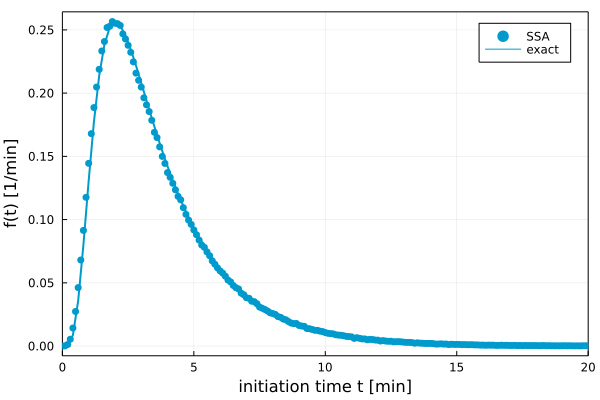

In [34]:
# add exact values to the plot

plot!(wtexact[!,1],wtexact[!,2],xlim=(0,20),line=2,color="deepskyblue3",label="exact")

In [ ]:
# export figure

# savefig(fig1, "wt-dist-Plec-K2.pdf")

# Transcription model

## Model reactions

In [35]:
# transcription model with stepwise initiation and fixed time elongation (K=2)

transcription = @reaction_network begin
    (k₁,k₋₁), S₁ <--> S₂
    (k₂,k₋₂), S₂ <--> S₃
    (k₃,k₋₃), S₃ <--> S₄
    (k₄,k₋₄), S₄ <--> S₅
    (k₅,k₋₅), S₅ <--> S₆
    (k₆,k₋₆), S₆ <--> S₇
    (k₇,k₋₇), S₇ <--> S₈
    (k₈,k₋₈), S₈ <--> S₉
    k₉, S₉ --> S₁₀
    k₁₀, S₁₀ --> S₄ + N
end k₁ k₋₁ k₂ k₋₂ k₃ k₋₃ k₄ k₋₄ k₅ k₋₅ k₆ k₋₆ k₇ k₋₇ k₈ k₋₈ k₉ k₁₀

Model ##ReactionSystem#283 with 18 equations
States (11):
  S₁(t)
  S₂(t)
  S₃(t)
  S₄(t)
  S₅(t)
  S₆(t)
⋮
Parameters (18):
  k₁
  k₋₁
  k₂
  k₋₂
  k₃
  k₋₃
⋮

In [ ]:
# check species

Catalyst.species(transcription)

In [ ]:
# check reactions

Catalyst.reactions(transcription)

## Model parameters

In [36]:
# set parameter values [1/min] 
k₁ = 0.04;
k₋₁ = 0.53;
k₂ = 1/1.1;
k₋₂ = 1/130.0;
k₃ = 1/(20.0/60);
k₋₃ = 1/8.0;
k₄ = 1/(3.2/60); 
k₋₄ = 1/(20*1.5/60);
k₅ = 30*2.3*10^(-3)*60;
k₋₅ = 3.0*10^(-3)*60;
k₆ = 1.7*10^(-2)*60;
k₋₆ = 5.0*10^(-2)*60;
k₇ = 5*10^(-2)*60;
k₋₇ = 1/5.0;
k₈ = 30*1.9*10^(-3)*60;
k₋₈ = 1.1*10^(-4)*60;
k₉ = 0.17*60;
k₁₀ = 1/0.5;

# elongation parameters
L = 60.404;
v = 4.3;
T=L/v;

print("elongation time [min] = ",T)

elongation time [min] = 14.047441860465117

## Stochastic simulations

In [43]:
# set model parameters
p = (k₁,k₋₁,k₂,k₋₂,k₃,k₋₃,k₄,k₋₄,k₅,k₋₅,k₆,k₋₆,k₇,k₋₇,k₈,k₋₈,k₉,k₁₀)

# set initial conditions (K=4)
u₀ = [0,0,0,1,0,0,0,0,0,0,0]

# set time interval to solve on
ts = 3*T;
tspan = (0.0,ts)

# convert to jump problem
jumpsys = convert(JumpSystem, transcription, combinatoric_ratelaws = false)

# check states
states(jumpsys)

11-element Vector{Term{Real, Base.ImmutableDict{DataType, Any}}}:
 S₁(t)
 S₂(t)
 S₃(t)
 S₄(t)
 S₅(t)
 S₆(t)
 S₇(t)
 S₈(t)
 S₉(t)
 S₁₀(t)
 N(t)

In [44]:
# define discrete problem
dprob = DiscreteProblem(u₀, tspan, p)

# non-Markovian part
delay_trigger_affect! = function (integrator, rng)
    append!(integrator.de_chan[1], T)
end
delay_trigger = Dict(18=>delay_trigger_affect!)
delay_complete = Dict(1=>[11=>-1]) 
delay_interrupt = Dict() 
delayjumpset = DelayJumpSet(delay_trigger,delay_complete,delay_interrupt)

# define delay problem
de_chan0 = [[]]
djprob = DelayJumpProblem(jumpsys, dprob, DelayRejection(), delayjumpset, de_chan0, save_positions=(false,false))


Number of constant rate jumps: 0
Number of variable rate jumps: 0
Have a mass action jump
Number of delay trigger reactions: 1
Number of delay interrupt reactions: 0


In [45]:
# number of individual trajectories
ntraj = 10^5

# run SSA for multiple trajectories
ensprob = EnsembleProblem(djprob)
@time ens = solve(ensprob, SSAStepper(), EnsembleThreads(), trajectories=ntraj);

  6.269745 seconds (24.37 M allocations: 1.504 GiB, 30.10% gc time, 0.20% compilation time)


In [46]:
# get nascent RNA numbers from individual trajectories

ndata = [ens[n].u[end][end] for n=range(1,ntraj)];

In [47]:
# maximum number of nascent RNA

maxRNA=findmax(ndata)[1]

9

In [48]:
# get the nascent RNA distribution P(N=n)

hP = fit(Histogram, ndata, 0:maxRNA+1)
hPnorm = normalize(hP,mode=:pdf)

Histogram{Float64, 1, Tuple{UnitRange{Int64}}}
edges:
  0:10
weights: [0.0028, 0.0307, 0.1235, 0.25469, 0.29512, 0.19521, 0.07651, 0.01864, 0.0026, 0.00023]
closed: left
isdensity: true

In [49]:
# export nascent RNA distribution to a table
using CSV
using DataFrames
PSSA = DataFrame(n=hPnorm.edges[1][1:end-1],P=hPnorm.weights)

,n,P
,Int64,Float64
1,0,0.0028
2,1,0.0307
3,2,0.1235
4,3,0.25469
5,4,0.29512
6,5,0.19521
7,6,0.07651
8,7,0.01864
9,8,0.0026


In [50]:
# export the table to a file

directory="C:\\Users\\jszav\\OneDrive\\Documents\\Research\\transcription-renewal"
filename="nascent-RNA-dist-Plec-K4-SSA.csv"
CSV.write(string(directory,"\\",filename), PSSA, writeheader=false)

"C:\\Users\\jszav\\OneDrive\\Documents\\Research\\transcription-renewal\\nascent-RNA-dist-Plec-K4-SSA.csv"

In [51]:
# plot the nascent RNA distribution

fig2=plot(PSSA[!,1],PSSA[!,2],
    seriestype=:scatter,
    xlabel="nascent RNA number n",
    ylabel="P(n)",
    framestyle=:box,
    label="SSA",
    color="orange",
    markerstrokecolor="orange");

In [52]:
# import exact data obtained by Mathematica

using CSV
using DataFrames
directory="C:\\Users\\jszav\\OneDrive\\Documents\\Research\\transcription-renewal"
filename="nascent-RNA-dist-Plec-K4-exact.csv"

Pexact = CSV.read(string(directory,"\\",filename), DataFrame, header=false);

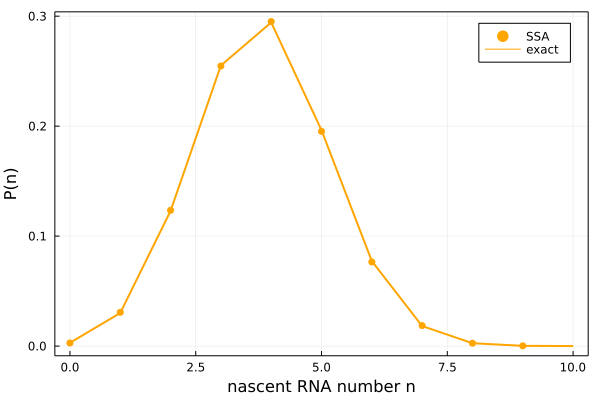

In [53]:
# add exact values to the plot

plot!(Pexact[!,1],Pexact[!,2],line=2,color="orange",label="exact")

In [ ]:
# export figure

# savefig(fig2, "nascent-RNA-dist-Plec-K2.pdf")